# Linear or Bayesian Regression to predict course prices?

In this section, we use Linear and Bayesian Linear Regression to predict course prices. Bayesian inference is an alternative to frequentist inference applied when the dataset is not enough huge to build robust models and/or we manage some prior knowlegde from the phenomenal studied. 

### Frequentist Linear Regression
Linear Regressions provides us a linear combination of weights multiplied by a set of predictor variables, $x$, that explains the behavior of the dependence variable $y$. Additionally, this equation includes a random sample error distributed normally. The matrix generalization of the linear model for any number of predictors is:

\begin{align*}
y = \beta^TX+\epsilon
\end{align*}

In Machine Learning, Linear Regression is used as supervised learning method where the learning process consists on using a training dataset to find the best coefficients $\beta$ that describe the observed variable. This best solution minizes the *RSS* or (Residual Sum of Squares), the total sum of squared difference between the observed variable $y$ and the predicted value for that observation.  

\begin{align*}
RSS = \sum_{n=1}^{N}(y_n-\hat{y})^2 = \sum_{n=1}^{N}(y_n-\beta^T{x_n})^2
\end{align*}

The minimization of RSS, called Ordinary Least Squares (OLS), that is the gradient of the RSS with respect to $\beta$ set to zero, give us the optimum or **maximum likelihood estimate of $\beta$**, the most probable coefficients given the inputs $X$ and outputs $y$. This method provides us a single estimate or weight for every model parameter based on the training data. It means that the model is built only over the data available. For small datasets, it makes more sense estimate probably values for our parameters.


The estimating equation for $\beta$, or $\hat{\beta}$ in matrix form is:

\begin{align*}
\hat{\beta}=(X^TX)^{-1}X^Ty
\end{align*}

Finally, using this $\hat{\beta}$ we are able to estimate the output value:

\begin{align*}
\hat{y} = \hat{\beta}^TX
\end{align*}

### Bayesian Linear Regression

In this case, the observed variable is a probability distribution. Asummming that the output can be represented as a normal distribution, the model for Bayesian Linear Regression is expresed as follows:

\begin{align*}
y \sim \mathcal{N}(\beta^TX,\sigma^2{I})
\end{align*}

where the mean is the transpose of the weight matrix, $\beta$, multiplied by the predictor matrix and the variance is the square of the standard deviation $\sigma$ of every parameter multiplied by the Identity matrix to dimensional adjustment.

Unlike Linear Regression, Bayesian Regression generates a distribution of possible predicted values, not only a single one. To do that, the model determines the posterior distribution for the model parameters (it means that the model assumes that the parameters come from distributions. 

According to Bayesian Inference, the posterior probability of the parameters is expressed as the conditional probability of the coefficients upon the training inputs $X$ and outputs $y$:

\begin{align*}
P(\beta|y, X)=\frac{P(y|\beta, X)P(\beta, X)}{P(y|X)}
\end{align*}


where:
- $P(y|\beta, X)$ is the likelihood of the data
- $P(\beta, X)$ is the prior probability of the parameters
- $P(y|X)$ is the normalization constant of Bayes theorem

Therefore, the distribution of possible model parameters depend on the data and prior knowlegde. The prior probability allows us include previous knowledge about the parameters in the model. Otherwise, the usual is using non-informative priors such as normal distribution. 

For small datasets, the uncertainty of the posterior distribution could be huge, but the increment of data shrinks the possible values until they become the same got by OLS for infinite data.

The posterior distribution can't be directly calculated because model parameters are distributions as well. Markov Chain Monte Carlo (MCMC) allows to build the most likely distribution generating random samples from the posterior distribution. Using normal priors for the parameters, we get random samples exploring and changing the value of parameters every time, each one limited to their own parameter space. As larger the samples generated, as accurate the posterior distribution. 

Is it possible to converge to the right distribution? Markov Chain limites random samples for the parameters based on the current state (parameter values) and the assumed prior distribution of the parameters (normal distribution is used to face no previous assumptions).

## Importing and cleaning data

Firstly, `df_courses` dataframe is imported from [initial_findings Jupyter Notebook](http://localhost:8889/notebooks/Documents/Udemy_project/Data_analysis/initial_findings.ipynb). Then, the columns `title`, `url` and `publishDate` are deleted and categorical data is transformed using labelEncoding from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [1]:
import pandas as pd
import seaborn as sns
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install pymc3

In [3]:
df_courses = pd.read_csv('../Data/interim/Courses.csv')

In [4]:
df_courses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3351 entries, 0 to 3350
Data columns (total 16 columns):
id                      3351 non-null int64
title                   3351 non-null object
url                     3351 non-null object
isPaid                  3351 non-null bool
price                   3351 non-null float64
numSubscribers          3351 non-null int64
numReviews              3351 non-null int64
numPublishedLectures    3351 non-null int64
instructionalLevel      3351 non-null object
contentInfo             3351 non-null object
publishedTime           3351 non-null object
category                3351 non-null object
timeSpent               3351 non-null float64
publishDate             3351 non-null object
level                   3351 non-null object
paidBool                3351 non-null bool
dtypes: bool(2), float64(2), int64(4), object(8)
memory usage: 373.1+ KB


In [5]:
df_courses.drop(columns=['url', 'isPaid', 'instructionalLevel', 'contentInfo', 'publishedTime'], inplace=True)

In [6]:
df_courses.head()

,id,title,price,numSubscribers,numReviews,numPublishedLectures,category,timeSpent,publishDate,level,paidBool
0,28295,Learn Web Designing & HTML5/CSS3 Essentials in...,75.0,43285,525,24,WebDevelopment,4.0,2013-01-03,All Levels,True
1,19603,Learning Dynamic Website Design - PHP MySQL an...,50.0,47886,285,125,WebDevelopment,12.5,2012-06-18,All Levels,True
2,889438,ChatBots: Messenger ChatBot with API.AI and No...,50.0,2577,529,64,WebDevelopment,4.5,2016-06-30,All Levels,True
3,197836,Projects in HTML5,60.0,8777,206,75,WebDevelopment,15.5,2014-06-17,Intermediate Level,True
4,505208,Programming Foundations: HTML5 + CSS3 for Entr...,20.0,23764,490,58,WebDevelopment,5.5,2015-10-17,Beginner Level,True


In [7]:
def labelEncoding(df, target_column, replace_column=False):
    """
    This method receive a dataframe and a string as the name of the column encoded. 
    It returns a column into the dataframe. The new column could replace the original 
    turning replace_column to True.
    """
    lb_make = LabelEncoder()
    encoded_name = lb_make.fit_transform(df[target_column])
    if replace_column:
        df.drop(columns=[target_column], inplace=True)
        
    return encoded_name

In [8]:
def levelEncoding(level):
    """
    This method establish the Encoding for the level of the course to assert that the digit assigned is sorted
    by difficulty.
    """
    if level == 'All Levels':
        return 0
    elif level == 'Beginner Level':
        return 1
    elif level == 'Intermediate Level':
        return 2
    else:
        return 3

In [9]:
df_courses['paidBool'] = labelEncoding(df_courses, 'paidBool', replace_column=True)
df_courses['category'] = labelEncoding(df_courses, 'category', replace_column=True)

In [10]:
df_courses['levelEncoding'] = df_courses.level.apply(levelEncoding)

In [11]:
df_courses.head()

,id,title,price,numSubscribers,numReviews,numPublishedLectures,timeSpent,publishDate,level,paidBool,category,levelEncoding
0,28295,Learn Web Designing & HTML5/CSS3 Essentials in...,75.0,43285,525,24,4.0,2013-01-03,All Levels,1,3,0
1,19603,Learning Dynamic Website Design - PHP MySQL an...,50.0,47886,285,125,12.5,2012-06-18,All Levels,1,3,0
2,889438,ChatBots: Messenger ChatBot with API.AI and No...,50.0,2577,529,64,4.5,2016-06-30,All Levels,1,3,0
3,197836,Projects in HTML5,60.0,8777,206,75,15.5,2014-06-17,Intermediate Level,1,3,2
4,505208,Programming Foundations: HTML5 + CSS3 for Entr...,20.0,23764,490,58,5.5,2015-10-17,Beginner Level,1,3,1


In [12]:
df_courses.drop(columns=['id', 'title', 'publishDate', 'level'], inplace=True)

In [13]:
df_courses.head()

,price,numSubscribers,numReviews,numPublishedLectures,timeSpent,paidBool,category,levelEncoding
0,75.0,43285,525,24,4.0,1,3,0
1,50.0,47886,285,125,12.5,1,3,0
2,50.0,2577,529,64,4.5,1,3,0
3,60.0,8777,206,75,15.5,1,3,2
4,20.0,23764,490,58,5.5,1,3,1


## Predicting prices using Linear Regression

Statsmodels is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. The model parameters are estimated using OLS.

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [15]:
y = df_courses.price
X = df_courses.drop(columns='price')

In [16]:
model_a = sm.OLS(y, X)
res = model_a.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     849.5
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:21:26   Log-Likelihood:                -18218.
No. Observations:                3351   AIC:                         3.645e+04
Df Residuals:                    3344   BIC:                         3.649e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
numSubscribers           0.0003      0.000      2.625      0.009    8.63e-05       0.001
numReviews               0.0022      0.001      1.671      0.095      -0.000       0.005
numPublishedLectures     0.2563      0.031      8.252      0.000       0.195       0.317
timeSpent                0.5682      0.255      2.226      0.026       0.068       1.069
paidBool                62.4680      1.762     35.456      0.000      59.014      65.922
category                -0.6371      0.771     -0.827      0.408      -2.148       0.874
levelEncoding           -3.3443      1.257     -2.661      0.008      -5.808      -0.880
==============================================================================
Omnibus:                      511.899   Durbin-Watson:                   1.746
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              774.459
Skew:                           1.162   Prob(JB):                    6.73e-169
Kurtosis:                       3.386   Cond. No.                     2.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The second warning suggest strong multicolinearity between the variables. Let's check the relation between the variables:

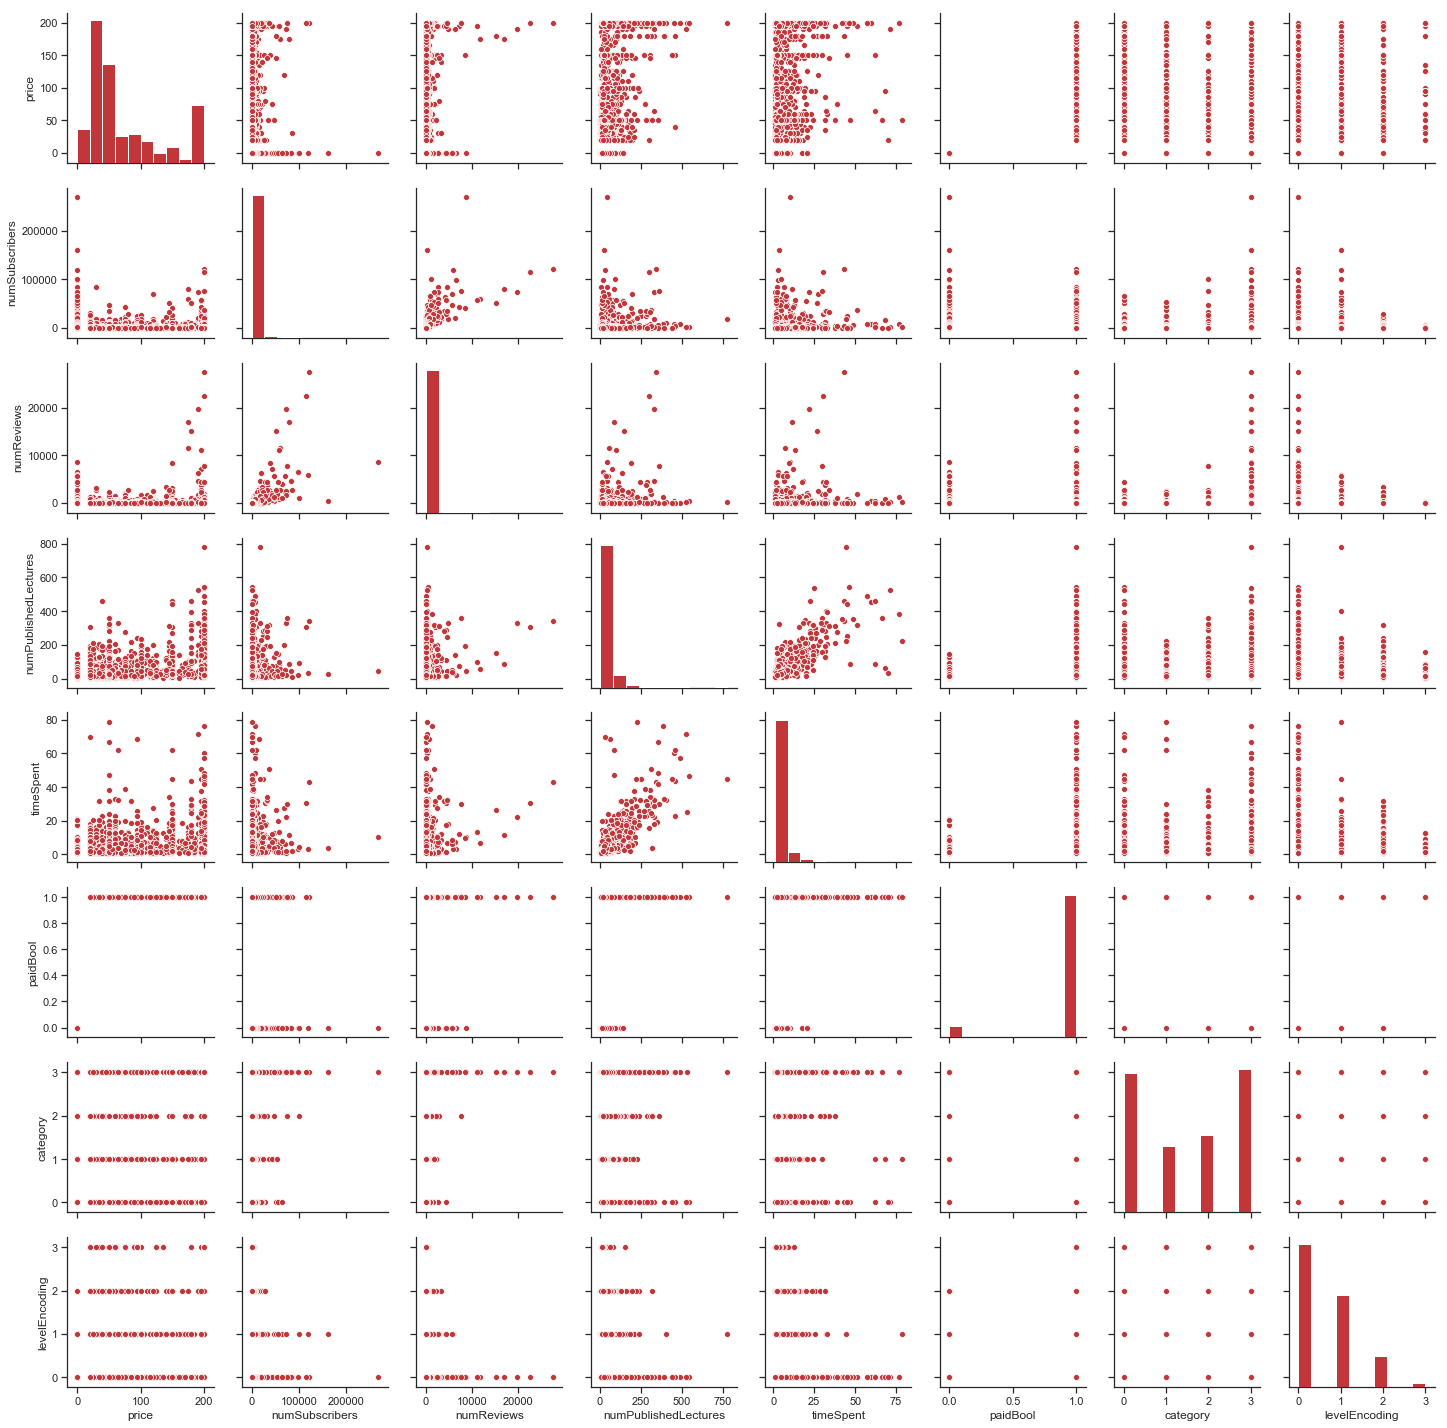

In [17]:
_ = sns.set(style="ticks", palette='RdBu', color_codes=True)
_ = sns.pairplot(df_courses)

The variables `timeSpent` and `numPublishedLectures` presents a strong relationship, as well as `numSubscribers` and `numReviews`. If you put attention on that, it makes sense absolutely! More subscribers in a specific course generate more possible reviews for their subscribers. At the same time, the courses with more lectures or lessons require more time to be completed. But additionally, `timeSpent` and `numPublishedLectures` are correlated with `numSubscribers` and `numReviews`.

We focus the attention on those 4 variables and trying different combination of them to get a performance similar to the previous model, which uses all the variables. An alternative model discarding `numSubscribers` and `numReviews`,

In [18]:
model_b = sm.OLS(y, X.drop(columns=['numSubscribers', 'numReviews']))
res = model_b.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     1176.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:21:34   Log-Likelihood:                -18230.
No. Observations:                3351   AIC:                         3.647e+04
Df Residuals:                    3346   BIC:                         3.650e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
numPublishedLectures     0.2682      0.031      8.650      0.000       0.207       0.329
timeSpent                0.6636      0.255      2.598      0.009       0.163       1.165
paidBool                61.3984      1.755     34.988      0.000      57.958      64.839
category                 0.2360      0.743      0.318      0.751      -1.220       1.692
levelEncoding           -3.3920      1.261     -2.691      0.007      -5.864      -0.921
==============================================================================
Omnibus:                      504.333   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              758.583
Skew:                           1.150   Prob(JB):                    1.89e-165
Kurtosis:                       3.381   Cond. No.                         133.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And this time, the model don't get a warning related to multicollinearity. But it is not ready yet. Inspecting the middle table, we find the mean value of every coefficient in the model, the confidence interval of plausible values and the p-value ($P>|t|$), which reveals the statisticall significant of every predictor in the observed output. p-value must be close to zero to means significant on the model and it's the case of all the predictors, except `category`. Checking the scatterplot of `category` and `price`, we note that the range of price is wide over all the categories of courses, thus the parameter is discarded from the final model:

In [19]:
model_c = sm.OLS(y, X.drop(columns=['numSubscribers', 'numReviews', 'category']))
res = model_c.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     1471.
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        23:21:34   Log-Likelihood:                -18230.
No. Observations:                3351   AIC:                         3.647e+04
Df Residuals:                    3347   BIC:                         3.649e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
numPublishedLectures     0.2696      0.031      8.781      0.000       0.209       0.330
timeSpent                0.6630      0.255      2.596      0.009       0.162       1.164
paidBool                61.6650      1.541     40.016      0.000      58.644      64.686
levelEncoding           -3.3399      1.250     -2.673      0.008      -5.790      -0.890
==============================================================================
Omnibus:                      502.496   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              754.850
Skew:                           1.147   Prob(JB):                    1.22e-164
Kurtosis:                       3.376   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Omnibus/Prob(Omnibus)** – a test of the skewness and kurtosis of the residual. We hope to see a value close to zero which would indicate normalcy. The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here. In this case Omnibus is relatively low and the Prob (Omnibus) is relatively high so the data is somewhat normal, but not altogether ideal. A linear regression approach would probably be better than random guessing but likely not as good as a nonlinear approach.

The **skew** measures the data symmetry. A value more than 1 indicates a highly and positive skewed distribution. A skew close to zero, indicating the residual distribution is normal. (This value also drives the Omnibus). 

**Kurtosis** – a measure of "peakiness", or curvature of the data. Higher peaks lead to greater Kurtosis. This distribution is leptokurtic (Kurtosis > 3), which means that data are heavy-tailed or profusion of outliers.

**Durbin-Watson** – tests for homoscedasticity. We hope to have a value between 1 and 2.

**Jarque-Bera (JB)/Prob(JB)** – like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test. With Prob(JB) less than 0.05, we reject the null hypothesis about the normal distribution for residuals.

## Predicting prices using Bayesian Linear Regression

We use the library PyMC3 for probabilistic programming and Bayesian Inference. The Generalized Linear Models (GLM) module is used to build the Bayesian Model and MCMC method. 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=21)

In [21]:
df_courses.head()

,price,numSubscribers,numReviews,numPublishedLectures,timeSpent,paidBool,category,levelEncoding
0,75.0,43285,525,24,4.0,1,3,0
1,50.0,47886,285,125,12.5,1,3,0
2,50.0,2577,529,64,4.5,1,3,0
3,60.0,8777,206,75,15.5,1,3,2
4,20.0,23764,490,58,5.5,1,3,1


In [24]:
df = df_courses.drop(columns=['numSubscribers', 'numReviews', 'category'])

In [25]:
# Formula for Bayesian Linear Regression
formula = 'price ~ ' + ' + '.join(['%s' % variable for variable in df.columns[1:]])
formula

'price ~ numPublishedLectures + timeSpent + paidBool + levelEncoding'

In [27]:
import pymc3 as pm

with pm.Model() as normal_model:
    
    # The prior for the data likelihood is a Normal Distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = df, family = family)
    
    # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
    normal_trace = pm.sample(draws=1500, chains = 2, tune = 200)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sd, levelEncoding, paidBool, timeSpent, numPublishedLectures, Intercept]
Sampling 2 chains, 16 divergences:  85%|████████▌ | 3761/4400 [02:00<01:33,  6.81draws/s]
The acceptance probability does not match the target. It is 0.9364970205210852, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
